In [1]:
# Import necessary libraries for file handling in Google Colab
from google.colab import files

# Prompt user to upload a file
uploaded = files.upload()

# Importing libraries to handle zip files and defining the file name
import zipfile
import io
file_name = 'data.zip'

# Extracting the contents of the uploaded zip file into the current directory
with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall('.')

Saving data.zip to data.zip


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from torchvision import transforms
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from PIL import Image
import os

##Data Loading
This segment focuses on loading data from different folders (rgb, waypoints, speed) associated with various scenarios. It reads image files (assuming .png format) from the 'rgb' folder, and corresponding waypoint and speed data from their respective folders for each scenario. The loaded data is stored in separate dictionaries (images_dict, speed_dict, waypoints_dict) for each scenario, allowing easy access and manipulation.


In [3]:
data_path = 'data'  # Define the base path where the data folders are located

# Fetch scenario folders by listing directories in the 'rgb' folder inside the data path
scenario_folders = [folder for folder in os.listdir(os.path.join(data_path, 'rgb')) if os.path.isdir(os.path.join(data_path, 'rgb', folder))]

# Initialize dictionaries to store data for each scenario in the key-value pair format
images_dict = {}
speed_dict = {}
waypoints_dict = {}

# Loop through each scenario folder to load data
for scenario_folder in scenario_folders:
    # Define paths for RGB images, waypoints, and speed data for each scenario
    rgb_path = os.path.join(data_path, 'rgb', scenario_folder)
    waypoints_path = os.path.join(data_path, 'waypoints', scenario_folder)
    speed_path = os.path.join(data_path, 'speed', scenario_folder)

    # Load waypoints and speed data from their respective .npy files
    waypoints_file = os.path.join(waypoints_path, 'waypoints.npy')
    waypoints_data = np.load(waypoints_file)

    speed_file = os.path.join(speed_path, 'speed.npy')
    speed_data = np.load(speed_file)

    # Load images, convert them to numpy arrays, and store in a list
    images_path = rgb_path  # Assuming images are directly in the scenario folder
    image_files = sorted([os.path.join(images_path, file) for file in os.listdir(images_path) if file.endswith('.png')])

    images_data = []
    for img_file in image_files:
        img = Image.open(img_file)
        img_array = np.array(img)
        images_data.append(img_array)

    # Store loaded data in separate dictionaries for each scenario
    images_dict[scenario_folder] = np.array(images_data)
    speed_dict[scenario_folder] = speed_data
    waypoints_dict[scenario_folder] = waypoints_data

    # Display loaded data information for each scenario
    print(f"Scenario: {scenario_folder}")
    print(f"Waypoints shape: {waypoints_data.shape}")
    print(f"Speed shape: {speed_data.shape}")
    print(f"Number of images: {len(images_data)}")
    print(f"Shape of an image array: {images_data[0].shape}")  # Assuming all images have the same shape

Scenario: 20230910-094935
Waypoints shape: (120, 4, 2)
Speed shape: (120, 1)
Number of images: 120
Shape of an image array: (160, 320, 3)
Scenario: 20230916-113025
Waypoints shape: (120, 4, 2)
Speed shape: (120, 1)
Number of images: 120
Shape of an image array: (160, 320, 3)


##Normalizing the Data

In [4]:
# Normalize images
for scenario in images_dict.keys():
    image_array = images_dict[scenario]
    images_dict[scenario] = image_array.astype('float64') / 255.0  # Normalize pixel values between 0 and 1

# Normalize speed
for scenario in speed_dict.keys():
    speed_array = speed_dict[scenario]
    min_speed = np.min(speed_array)
    max_speed = np.max(speed_array)
    speed_dict[scenario] = (speed_array - min_speed) / (max_speed - min_speed)  # Normalize speed values between 0 and 1

# Normalize waypoints
for scenario in waypoints_dict.keys():
    waypoints_array = waypoints_dict[scenario]
    min_x = np.min(waypoints_array[:, 0])
    max_x = np.max(waypoints_array[:, 0])
    min_y = np.min(waypoints_array[:, 1])
    max_y = np.max(waypoints_array[:, 1])

    # Normalize x and y coordinates separately
    waypoints_array[:, 0] = (waypoints_array[:, 0] - min_x) / (max_x - min_x)
    waypoints_array[:, 1] = (waypoints_array[:, 1] - min_y) / (max_y - min_y)
    waypoints_dict[scenario] = waypoints_array

##Reshaping the Image and Speed Dimensions


In [5]:
# Assuming you have NumPy arrays in images_dict, speed_dict, and waypoints_dict
image_tensor = {key: torch.from_numpy(arr) for key, arr in images_dict.items()}
speed_tensor = {key: torch.from_numpy(arr) for key, arr in speed_dict.items()}
waypoint_tensor = {key: torch.from_numpy(arr) for key, arr in waypoints_dict.items()}

# Reshape images to have the same number of dimensions
for key, tensor in image_tensor.items():
    image_tensor[key] = tensor.permute(0, 3, 1, 2)  # Assuming image tensor is in HWC format (Height, Width, Channels)

# Normalize speed tensors to match the shape of images
for key, tensor in speed_tensor.items():
    if tensor.shape != image_tensor[key].shape[1:]:
        # Reshape or perform operations to match the required shape
        speed_tensor[key] = tensor.reshape(-1, 1, 1, 1).expand_as(image_tensor[key])

# Check the shapes after processing
#for key in image_tensor.keys():
#    print(f"Images Tensor '{key}' Shape: {image_tensor[key].shape}")
#    print(f"Speed Tensor '{key}' Shape: {speed_tensor[key].shape}")
#    print(f"Waypoint Tensor '{key}' Shape: {waypoint_tensor[key].shape}")

## Creating Custom Data Loaders

In [6]:
from sklearn.model_selection import train_test_split
from typing import List, Tuple

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_tensor, speed_tensor, waypoint_tensor):
        self.image_tensor = image_tensor.float()
        self.speed_tensor = speed_tensor.float()
        self.waypoint_tensor = waypoint_tensor.float()

    def __len__(self):
        return len(self.image_tensor)

    def __getitem__(self, idx):
        image = self.image_tensor[idx]
        speed = self.speed_tensor[idx]
        waypoints = self.waypoint_tensor[idx]
        return image, speed, waypoints

# CustomDataset class definition remains the same as provided in the initial code snippet

def create_data_loaders(image_tensors: List[torch.Tensor],
                        speed_tensors: List[torch.Tensor],
                        waypoint_tensors: List[torch.Tensor],
                        batch_size: int = 20,
                        test_size: float = 0.2,
                        random_state: int = 42) -> List[Tuple[DataLoader, DataLoader]]:
    loaders: List[Tuple[DataLoader, DataLoader]] = []
    for i in range(len(image_tensors)):
        dataset = CustomDataset(image_tensors[i], speed_tensors[i], waypoint_tensors[i])
        indices = list(range(len(dataset)))
        train_indices, test_indices = train_test_split(indices, test_size=test_size, random_state=random_state)

        train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
        test_sampler = torch.utils.data.sampler.SubsetRandomSampler(test_indices)

        train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
        test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

        loaders.append((train_loader, test_loader))

    return loaders

# Assuming 'scenarios_loaders' is generated from 'create_data_loaders' function
scenarios_loaders = create_data_loaders([image_tensor[key] for key in image_tensor],
                                        [speed_tensor[key] for key in speed_tensor],
                                        [waypoint_tensor[key] for key in waypoint_tensor])

def create_scenario_loaders(scenarios_loaders: List[Tuple[DataLoader, DataLoader]],
                            n: int,
                            batch_size: int = 20) -> List[Tuple[str, DataLoader]]:
    result_loaders: List[Tuple[str, DataLoader]] = []
    for i, (train_loader, test_loader) in enumerate(scenarios_loaders[:n], 1):
        result_loaders.append((f"train_loader_{i}", train_loader))
        result_loaders.append((f"test_loader_{i}", test_loader))

    return result_loaders

n = 2  # number of scenarios
resulting_loaders = create_scenario_loaders(scenarios_loaders, n)


## CNN-LSTM Hybrid Model Architecture

In [7]:
# Define a custom CNN model
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        # Define the layers for the CNN
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)

        x = self.relu(self.conv2(x))
        x = self.maxpool(x)

        x = self.relu(self.conv3(x))
        x = self.maxpool(x)

        x = self.relu(self.conv4(x))
        x = self.avgpool(x)

        x = torch.flatten(x, 1)
        return x

# HybridModel to use the CustomCNN
class HybridModel(nn.Module):
    def __init__(self, num_waypoints=4):
        super(HybridModel, self).__init__()
        # Custom CNN for images
        self.cnn = CustomCNN()

        # LSTM for speeds
        self.lstm = nn.LSTM(input_size=160, hidden_size=256, num_layers=2, batch_first=True)

        # Linear layer for output waypoints
        self.fc = nn.Linear(512 + 256, num_waypoints * 2)  # Output of CustomCNN is 512

    def forward(self, images, speeds):
        img_features = self.cnn(images)
        images = images.float()
        speeds = speeds.float()
        speeds = speeds.reshape(speeds.size(0), speeds.size(2), -1)
        speeds = speeds.permute(0, 2, 1)
        _, (speeds_out, _) = self.lstm(speeds)

        combined = torch.cat((img_features, speeds_out[-1]), dim=1)
        waypoints = self.fc(combined)
        waypoints = waypoints.reshape(-1, 4, 2)

        return waypoints

## Train and Evaluation Function Definition

In [8]:
from sklearn.metrics import r2_score

# Train Function
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    r2_accumulator = 0.0

    for images, speeds, waypoints in train_loader:
        images, speeds, waypoints = images.to(device), speeds.to(device), waypoints.to(device)
        images = images.float()
        speeds = speeds.float()

        optimizer.zero_grad()
        outputs = model(images, speeds)
        loss = criterion(outputs, waypoints)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate R2 score
        predicted = outputs.detach().cpu().numpy()
        true_values = waypoints.detach().cpu().numpy()
        r2 = r2_score(true_values.flatten(), predicted.flatten())
        r2_accumulator += r2

    avg_r2 = r2_accumulator / len(train_loader)
    return running_loss / len(train_loader), avg_r2

# Evaluate Function
def evaluate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    r2_accumulator = 0.0
    all_true_values = []
    all_predicted_values = []

    with torch.no_grad():
        for images, speeds, waypoints in val_loader:
            images, speeds, waypoints = images.to(device), speeds.to(device), waypoints.to(device)
            images = images.float()
            speeds = speeds.float()

            outputs = model(images, speeds)
            loss = criterion(outputs, waypoints)
            running_loss += loss.item()

            # Calculate R2 score
            predicted = outputs.detach().cpu().numpy()
            true_values = waypoints.detach().cpu().numpy()
            r2 = r2_score(true_values.flatten(), predicted.flatten())
            r2_accumulator += r2

    avg_r2 = r2_accumulator / len(val_loader)
    return running_loss / len(val_loader), avg_r2


## Training and Evaluation Loop

Dataloader 0 - Epoch [1/20] - Train Loss: 28.8137 - Test Loss: 16.4184
Dataloader 0 - Epoch [2/20] - Train Loss: 13.0731 - Test Loss: 5.9073
Dataloader 0 - Epoch [3/20] - Train Loss: 10.4030 - Test Loss: 8.2388
Dataloader 0 - Epoch [4/20] - Train Loss: 10.7300 - Test Loss: 11.3843
Dataloader 0 - Epoch [5/20] - Train Loss: 8.3069 - Test Loss: 4.8969
Dataloader 0 - Epoch [6/20] - Train Loss: 8.2289 - Test Loss: 3.7178
Dataloader 0 - Epoch [7/20] - Train Loss: 6.8409 - Test Loss: 2.9427
Dataloader 0 - Epoch [8/20] - Train Loss: 6.0684 - Test Loss: 2.3540
Dataloader 0 - Epoch [9/20] - Train Loss: 6.3509 - Test Loss: 1.5975
Dataloader 0 - Epoch [10/20] - Train Loss: 6.4505 - Test Loss: 3.1003
Dataloader 0 - Epoch [11/20] - Train Loss: 5.9087 - Test Loss: 1.1285
Dataloader 0 - Epoch [12/20] - Train Loss: 5.3076 - Test Loss: 1.5019
Dataloader 0 - Epoch [13/20] - Train Loss: 6.6798 - Test Loss: 3.5638
Dataloader 0 - Epoch [14/20] - Train Loss: 7.5517 - Test Loss: 4.4851
Dataloader 0 - Epoch [1

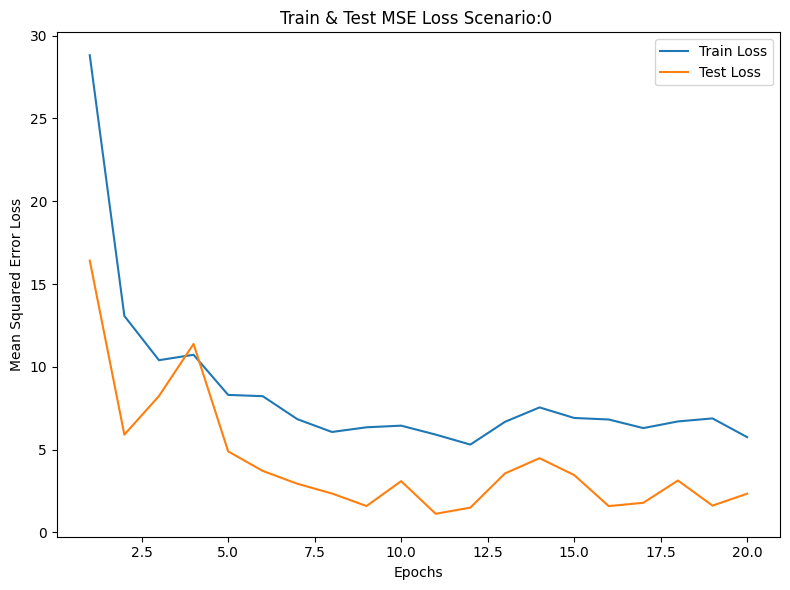

Dataloader 2 - Epoch [1/20] - Train Loss: 31.7547 - Test Loss: 17.0141
Dataloader 2 - Epoch [2/20] - Train Loss: 14.2702 - Test Loss: 22.6221
Dataloader 2 - Epoch [3/20] - Train Loss: 11.3355 - Test Loss: 9.6687
Dataloader 2 - Epoch [4/20] - Train Loss: 11.5531 - Test Loss: 5.2076
Dataloader 2 - Epoch [5/20] - Train Loss: 9.9700 - Test Loss: 5.7819
Dataloader 2 - Epoch [6/20] - Train Loss: 8.5781 - Test Loss: 5.0510
Dataloader 2 - Epoch [7/20] - Train Loss: 7.5656 - Test Loss: 5.7344
Dataloader 2 - Epoch [8/20] - Train Loss: 6.5849 - Test Loss: 4.6135
Dataloader 2 - Epoch [9/20] - Train Loss: 6.6415 - Test Loss: 4.4984
Dataloader 2 - Epoch [10/20] - Train Loss: 6.1304 - Test Loss: 3.7227
Dataloader 2 - Epoch [11/20] - Train Loss: 6.2779 - Test Loss: 1.5969
Dataloader 2 - Epoch [12/20] - Train Loss: 5.9358 - Test Loss: 2.9305
Dataloader 2 - Epoch [13/20] - Train Loss: 5.2266 - Test Loss: 1.9496
Dataloader 2 - Epoch [14/20] - Train Loss: 5.4506 - Test Loss: 2.6029
Dataloader 2 - Epoch [1

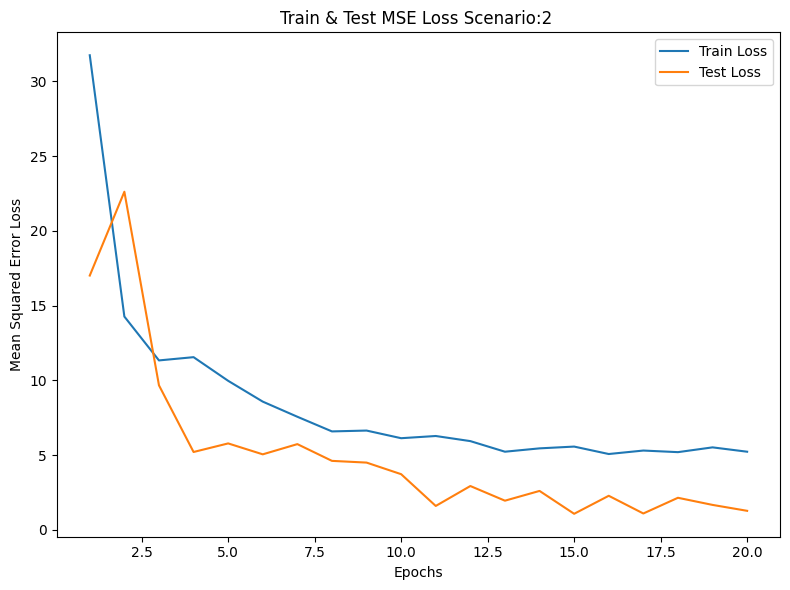

In [9]:
import matplotlib.pyplot as plt

for i in range(0, len(resulting_loaders), 2):
    train_loader_name, train_loader = resulting_loaders[i]
    test_loader_name, test_loader = resulting_loaders[i + 1]


    # Training loop for DataLoaders with both MSE and R2 evaluation
    num_epochs = 20
    train_losses = []
    test_losses = []
    train_r2_score = []  # List to store train R2 scores
    test_r2_score = []  # List to store test R2 scores

    model = HybridModel()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Move model to device
    model.to(device)

    for epoch in range(num_epochs):
        # Training
        train_loss, train_r2 = train(model, train_loader, optimizer, criterion, device)
        train_losses.append(train_loss)
        train_r2_score.append(train_r2)
        # Testing during training
        test_loss, test_r2 = evaluate(model, test_loader, criterion, device)
        test_losses.append(test_loss)
        test_r2_score.append(test_r2)
        #print(f"Dataloader {i+1} - Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f} - Test Loss: {test_loss:.4f} - Train R2: {train_r2:.4f} - Test R2: {test_r2:.4f}")
        print(f"Dataloader {i} - Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f} - Test Loss: {test_loss:.4f}")


    # Testing loop for DataLoaders with both MSE and R2 evaluation
    test_loss_1, test_r2_1 = evaluate(model, test_loader, criterion, device)
    print(f"Overall Test Loss (MSE): {test_loss_1:.4f} - Test R2 Score: {test_r2_1:.4f}")

    # Plotting the training and test losses for Scenario
    plt.figure(figsize=(8, 6))
    #plt.subplot(2, 1, 1)
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error Loss')
    plt.title(f'Train & Test MSE Loss Scenario:{i} ')
    plt.legend()
    plt.tight_layout()
    plt.show()


